In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy
import netgraph

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']

def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']


def summarize_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    for d in data:        
        for result in d["reasons"]:
            if result and 'reason' in result.keys() and d['n'] == 50 and d['simulation'] == 0:
                reason_list[d['temperature']].append(result['reason'])


    for k, v in sorted(reason_list.items()):    
        print(f'For temperature {k} the top 3 reasons are:')
        prompt = f"""
        # Task
        You are given a list of reasons and your task is to summarize them. You must identify the general pattern in the reasons and summarize them in a few sentences.
        You should avoid identifying specific persons.

        # Input
        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(v, indent=4)}
        </REASONS>
        """

        ans = get_response(prompt, temperature=0.9, system_prompt="You are a helpful assistant")

        print(ans)

def network_growth(n0, temperature, method='llm'):
    G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]], seed=0)

    Gs = []
    results = []

    for t in G.nodes():

        if method == 'llm':
            result = select_neighbor(G, t, temperature)
            if result:
                v = result['name']
                G.add_edge(t, v)
                results.append(result)
        elif method == 'random':
            v = random.choice(list(set(G.nodes() - set(G.neighbors(t)))))
            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'random'})
        elif method == 'winner':
            v = None,
            max_common_friends = 0
            for u in G.nodes():
                if u not in G.neighbors(t) and u != t and len(set(G.neighbors(u)) & set(G.neighbors(t))) > max_common_friends:
                    v = u
                    max_common_friends = len(set(G.neighbors(u)) & set(G.neighbors(t)))

            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'winner'})

        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature):
    common_friends = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            common_friends.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t)))})

    prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. Each dictionary has two keys: 'name' and 'common friends'.
    'name' is the name of the person and 'number_of_common_friends' are the common friends you have with the other person.
    The data is given below after chevrons:
    <DEGREES>
    {json.dumps(common_friends, indent=4)}
    </DEGREES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "common_friends" : the common friends of the person you selected,
        "reason" : reason for selecting the person
    }}

    # Notes
    - The output must be a valid JSON object.

    ```json
    """   

    for i in range(10):
        try:
            result = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():    
                print('COMMON FRIENDS', common_friends)
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None, use_netgraph=True):

    if not use_netgraph:
        pos = nx.spring_layout(G)
        group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
        group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]

        node_color = ['#d35400' if n in group_1 else '#2980b9' for n in G.nodes()]

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=0.5, node_color=node_color, alpha=0.7, edge_color='#34495e')
        else:
            G0_edges = set(G0.edges())
            G_edges = set(G.edges()) - G0_edges

            G_group_1 = set(nx.subgraph(G, group_1).edges()) & G_edges
            G_group_2 = set(nx.subgraph(G, group_2).edges()) & G_edges
            G_between = G_edges - G_group_1 - G_group_2

            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=0.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_between, width=1.0, alpha=1, edge_color='#f1c40f', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_group_1, width=1.0, alpha=1, edge_color='#d35400', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_group_2, width=1.0, alpha=1, edge_color='#2980b9', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=node_color, alpha=0.7, ax=ax)
    else:
        node2community = {i: 0 if i < len(G.nodes()) // 2 else 1 for i in G.nodes()}
        node_color = {i : '#d35400' if node2community[i] == 0 else  '#2980b9' for i in G.nodes()}
        edge_color = {(u, v) : '#34495e' if node2community[u] != node2community[v] else ['#d35400', '#2980b9'][node2community[u]] for (u, v) in G.edges()}

        netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_color=edge_color, edge_layout='bundled', edge_layout_kwargs=dict(k=2000), ax=ax)

    ax.set_axis_off()

def analyze_experiments(filename):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))


    clustering_coefficients = collections.defaultdict(list)
    algebraic_connectivities = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            Gs.append(G)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        fig.suptitle(f'Temperature = {d["temperature"]}')

        for i, t in enumerate([0, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            draw_graph(G, ax=ax[i], G0=Gs[0])

            # print(d['reasons'])

        final_graphs[d['n'], d['temperature']].append((Gs[-1], Gs[0]))

        clustering_coefficient = [nx.average_clustering(G) for G in Gs]

        algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

        # ax[-1].set_title('Metrics')
        ax[-1].plot(clustering_coefficient, label='Clustering Coefficient', color='#d35400')

        ax_y = ax[-1].twinx()

        ax_y.plot(algebraic_connectivity, label='Algebraic Connectivity', color='#2980b9')
        ax[-1].set_xlabel('t')
        ax[-1].set_ylabel('Average Clustering Coefficient', color='#d35400')
        ax_y.set_ylabel('Algebraic Connectivity', color='#2980b9')

        clustering_coefficients[d['n'], d['temperature']].append(clustering_coefficient)
        algebraic_connectivities[d['n'], d['temperature']].append(algebraic_connectivity)

        fig.tight_layout()
        fig.savefig(f'figures/principle_2/principle_2_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png', dpi=300)

    palette = ['#e67e22', '#f1c40f', '#7f8c8d', '#d35400', '#34495e', '#2980b9']


    fig, ax = plt.subplots(2, len(clustering_coefficients), figsize=(5 * len(clustering_coefficients), 10), squeeze=False, sharey='row')

    fig_combined, ax_combined = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)


    ax_combined[0, 0].set_ylabel('Average Clustering Coefficient')
    ax_combined[0, 1].set_ylabel('Algebraic Connectivity')
    ax_combined[0, 0].set_xlabel('t')
    ax_combined[0, 1].set_xlabel('t')

    ax_combined[0, 0].set_xlim(0, 49)
    ax_combined[0, 1].set_xlim(0, 49)

    for i, (k, c) in enumerate(zip(sorted(clustering_coefficients.keys()), palette)):
        v = clustering_coefficients[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))

        ax[0, i].plot(mean, color='#2980b9', label='LLM')
        ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')

        ax[0, i].set_title(f'Temperature = {k[1]}')

        ax[0, i].set_xlabel('t')

        if i == 0:
            ax[0, i].set_ylabel('Average Clustering Coefficient')

        ax[0, i].set_ylim(0.35, 0.5)

        ax[0, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 0].plot(mean, color=c, label='Temp = ' + str(k[1]))
        ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

    ax_combined[0, 0].set_ylim(0.35, 0.5)



    for i, (k, c) in enumerate(zip(sorted(algebraic_connectivities.keys()), palette)):
        v = algebraic_connectivities[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))


        ax[1, i].plot(mean, color='#2980b9', label='LLM')
        ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')
        ax[1, i].set_ylim(3.5, 6)

        ax[1, i].set_xlim(0, len(mean) - 1)

        if i == 0:
            ax[1, i].set_ylabel('Algebraic Connectivity')

        ax_combined[0, 1].plot(mean, color=c, label='Temp = ' + str(k[1]))
        ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)



    # Null models
    clustering_coefficients_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list) }
    algebraic_connectivities_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list) }

    for d in data:
        for method in ['random', 'winner']:
            Gs, _ = network_growth(d['n'], d['temperature'], method=method)

            clustering_coefficient = [nx.average_clustering(G) for G in Gs]

            clustering_coefficients_null[method][d['n'], d['temperature']].append(clustering_coefficient)

            algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

            algebraic_connectivities_null[method][d['n'], d['temperature']].append(algebraic_connectivity)

    for method in ['random', 'winner']:
        for i, (k, v) in enumerate(clustering_coefficients_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            ax[0, i].plot(mean, color='#d35400' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400' if method == 'random' else '#34495e')

            if i == 0:
                ax_combined[0, 0].plot(mean, color='#d35400' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
                ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400' if method == 'random' else '#34495e')

        for i, (k, v) in enumerate(algebraic_connectivities_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            ax[1, i].plot(mean, color='#d35400' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400' if method == 'random' else '#34495e')
            if i == 0:
                ax_combined[0, 1].plot(mean, color='#d35400' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
                ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400' if method == 'random' else '#34495e', hatch='||')

    ax[0, 0].legend(loc='upper left')
    ax[1, 0].legend(loc='upper left')

    ax_combined[0, 0].legend(loc='upper left')
    # ax_combined[0, 1].legend(loc='upper left')

    fig_combined.tight_layout()

    fig.tight_layout()

    fig.savefig('figures/principle_2/principle_2_overall.png', dpi=300)

    fig_combined.savefig('figures/principle_2/principle_2_overall_combined.png', dpi=300)

    fig_final, ax_final = plt.subplots(1, len(final_graphs), figsize=(5 * len(final_graphs), 5), squeeze=False)

    for i, (k, v) in enumerate(sorted(final_graphs.items())):
        G, G0 = v[0]
        draw_graph(G, ax=ax_final[0, i], G0=G0)

        ax_final[0, i].set_title(f'Temperature = {k[1]}')

    fig_final.tight_layout()

    fig_final.savefig('figures/principle_2/principle_2_final.png', dpi=300)


Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulation for n=50, i=3, temperature=1.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=4, temperature=1.0
Skipping simulation for n=50, i=4, temperature=1.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=5, temperature=1.0
Skipping simulation for n=50, i=5, temperature=1.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_45804/2092476217.py:262: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))

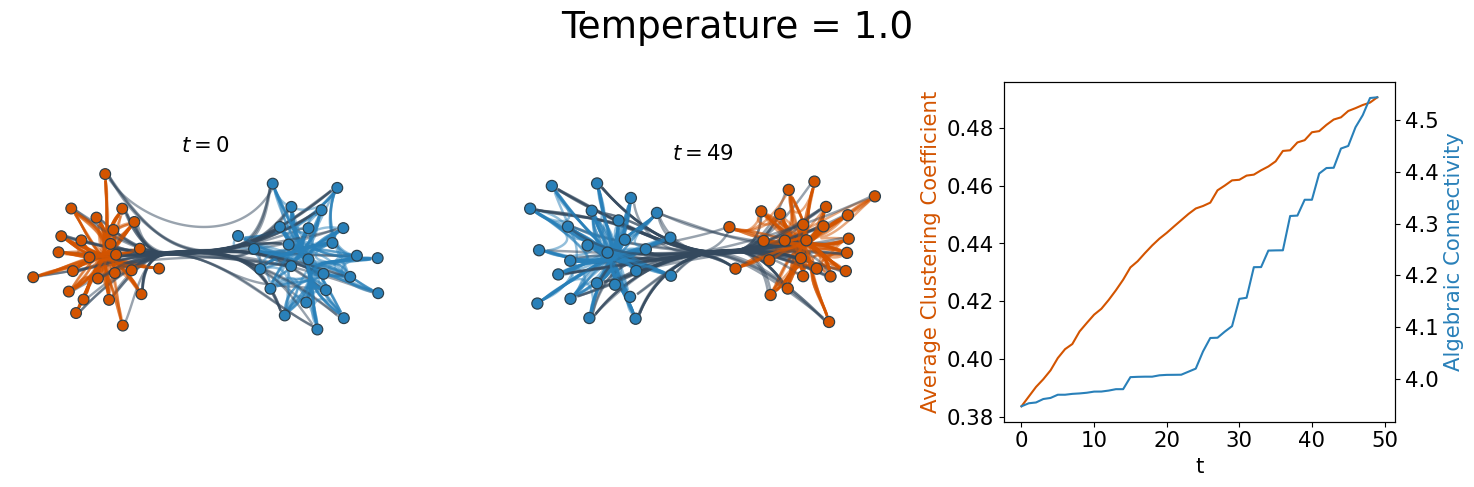

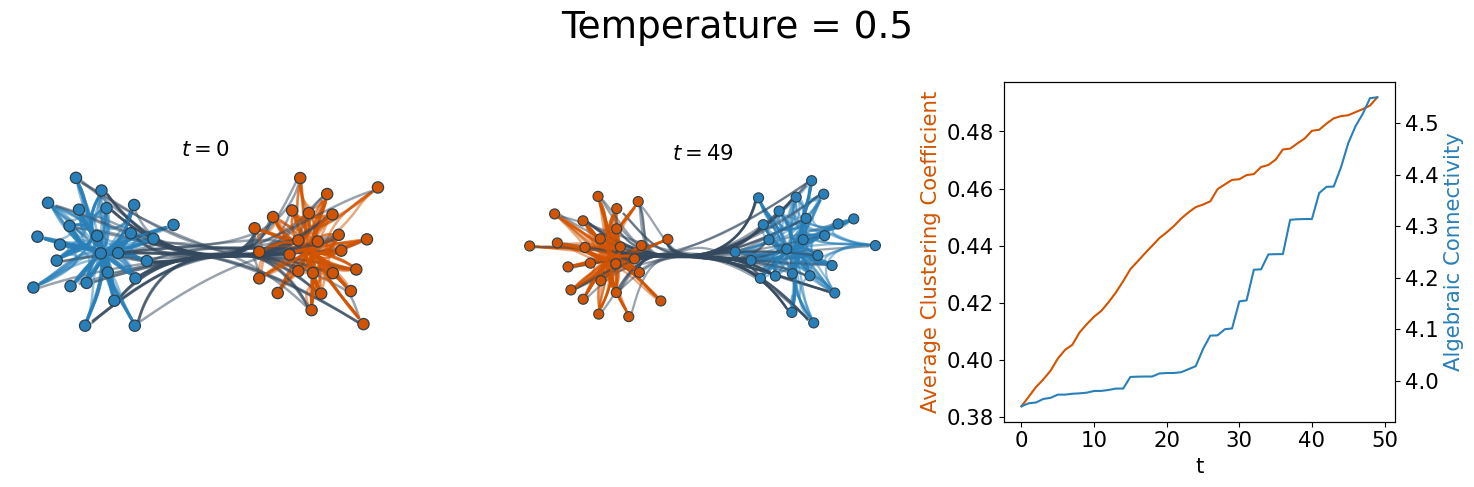

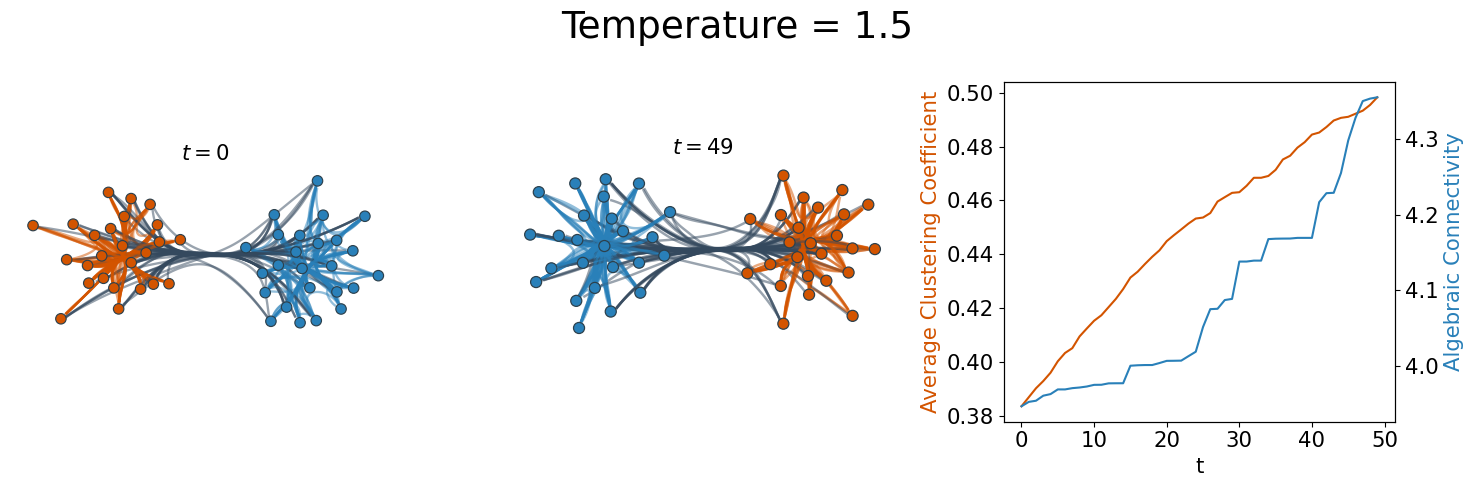

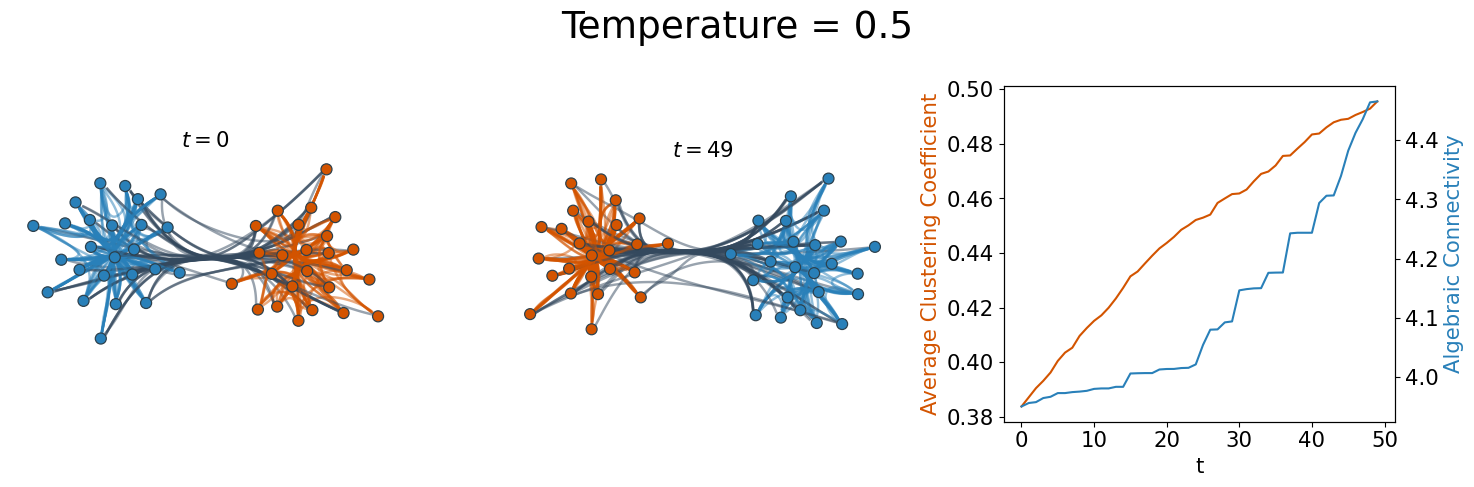

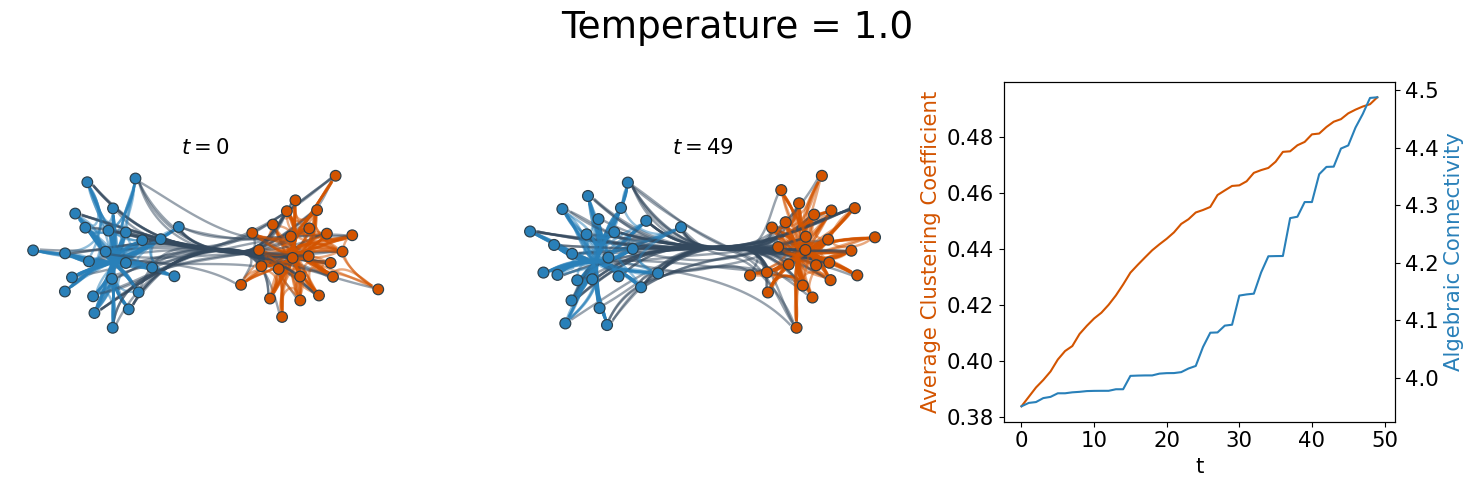

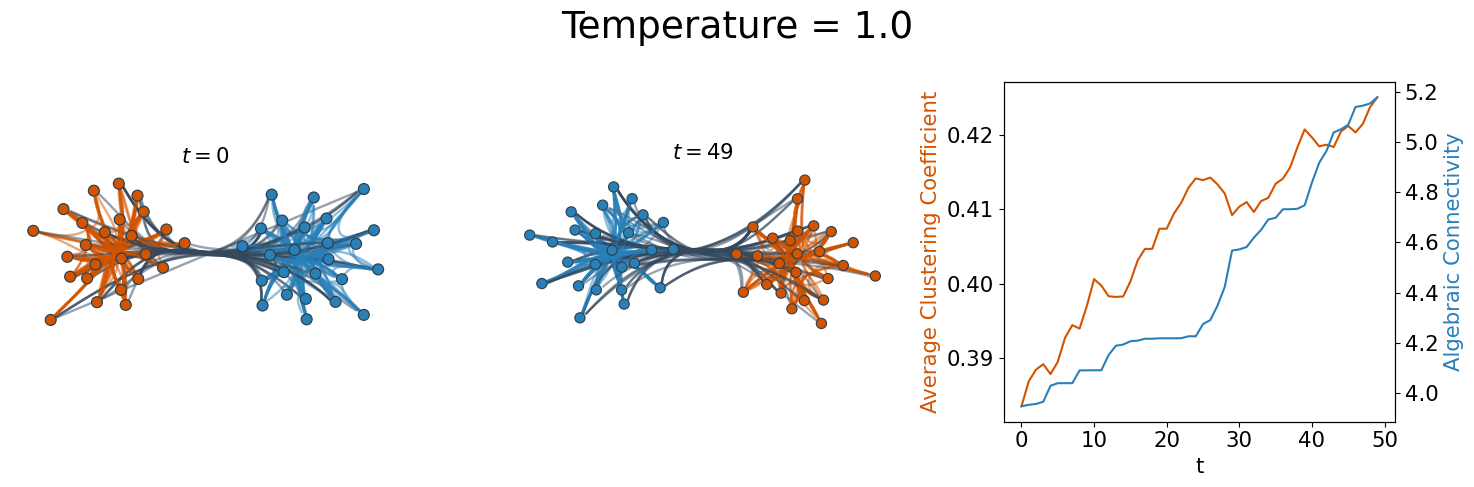

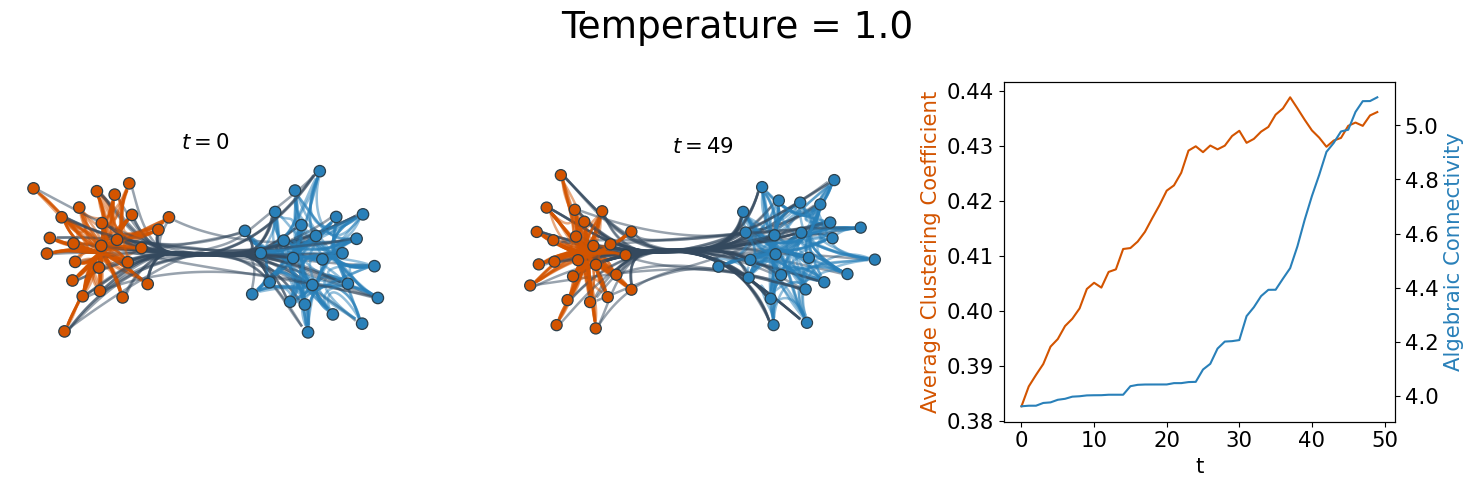

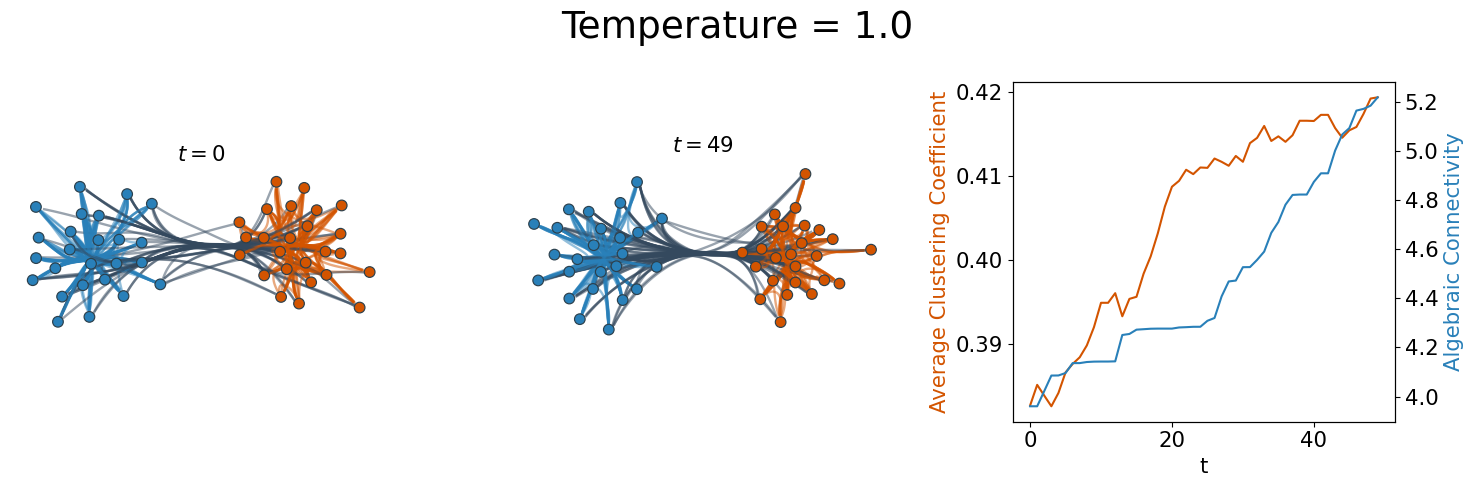

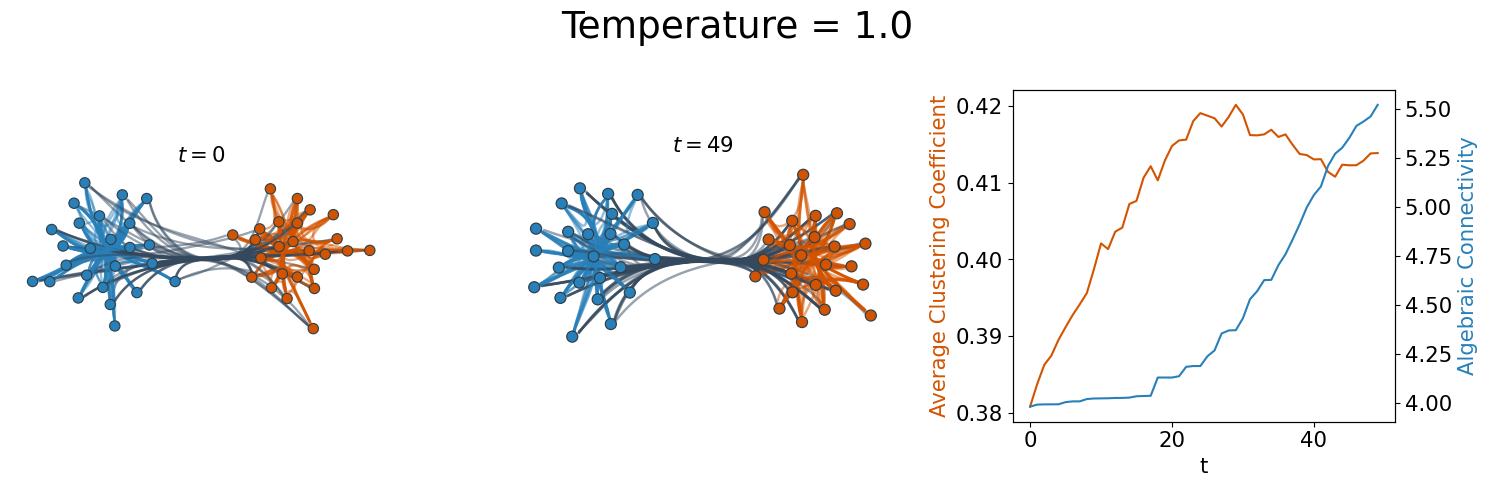

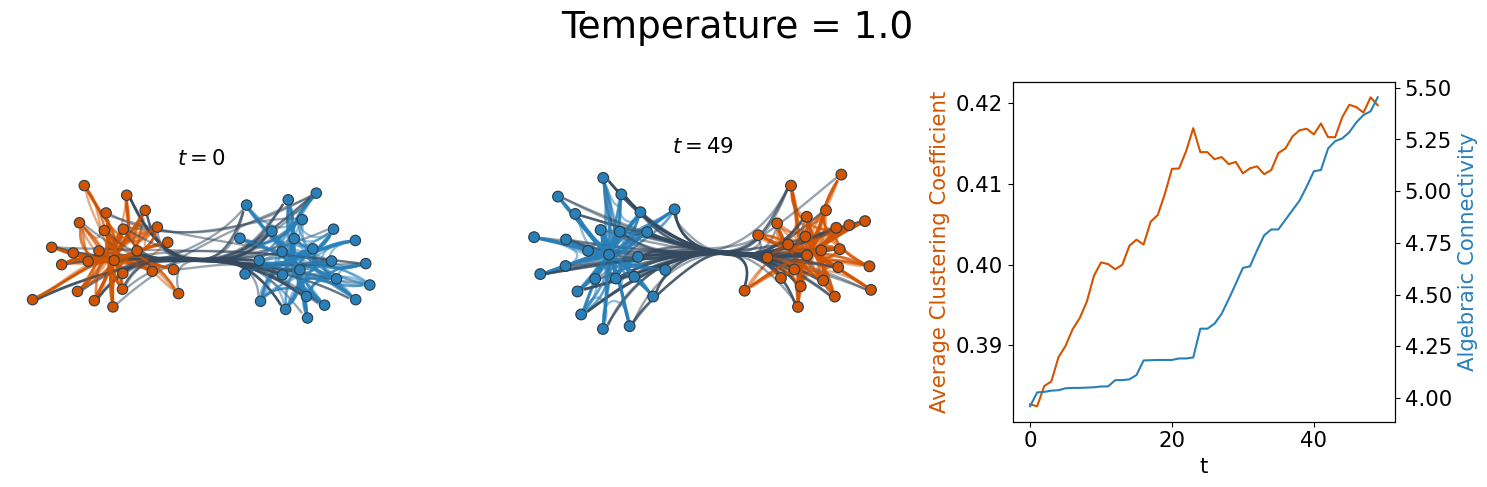

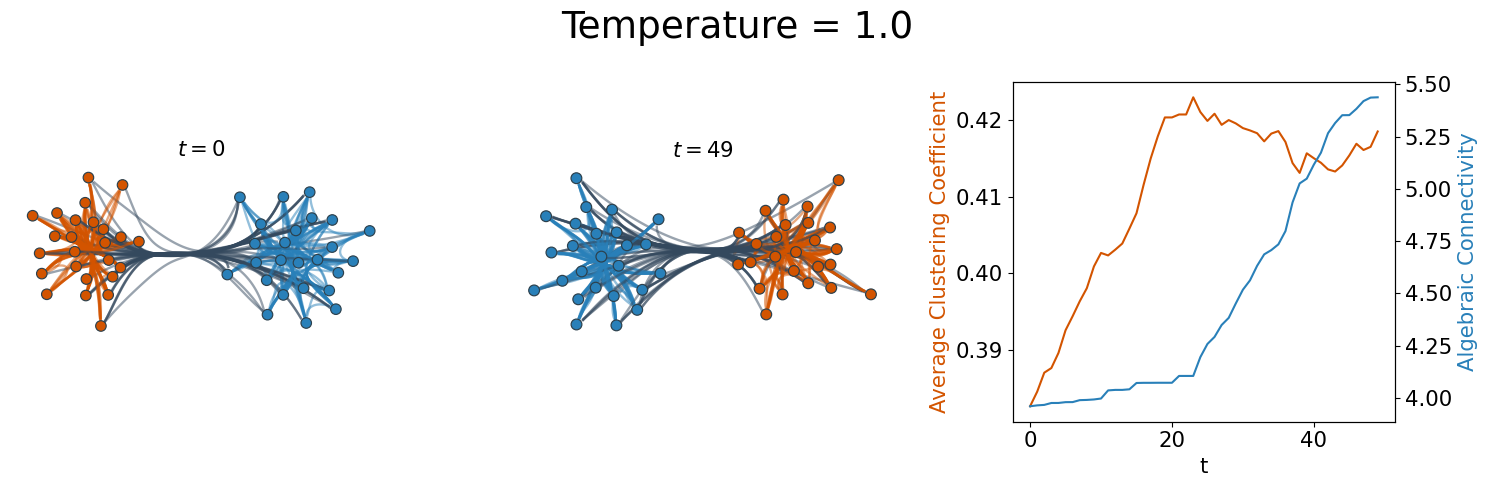

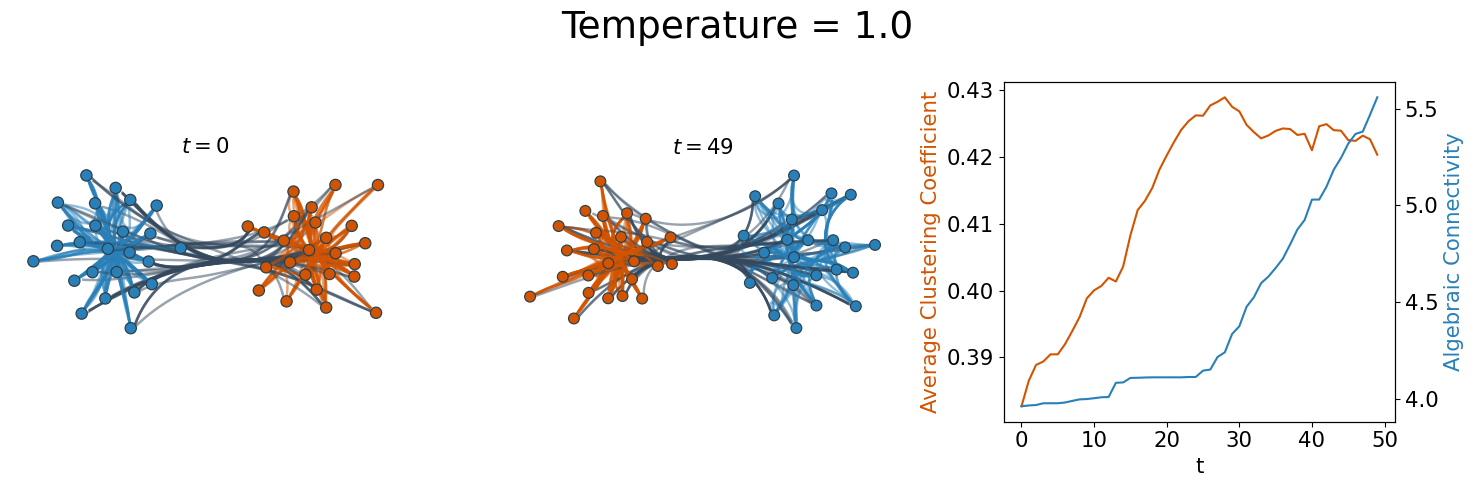

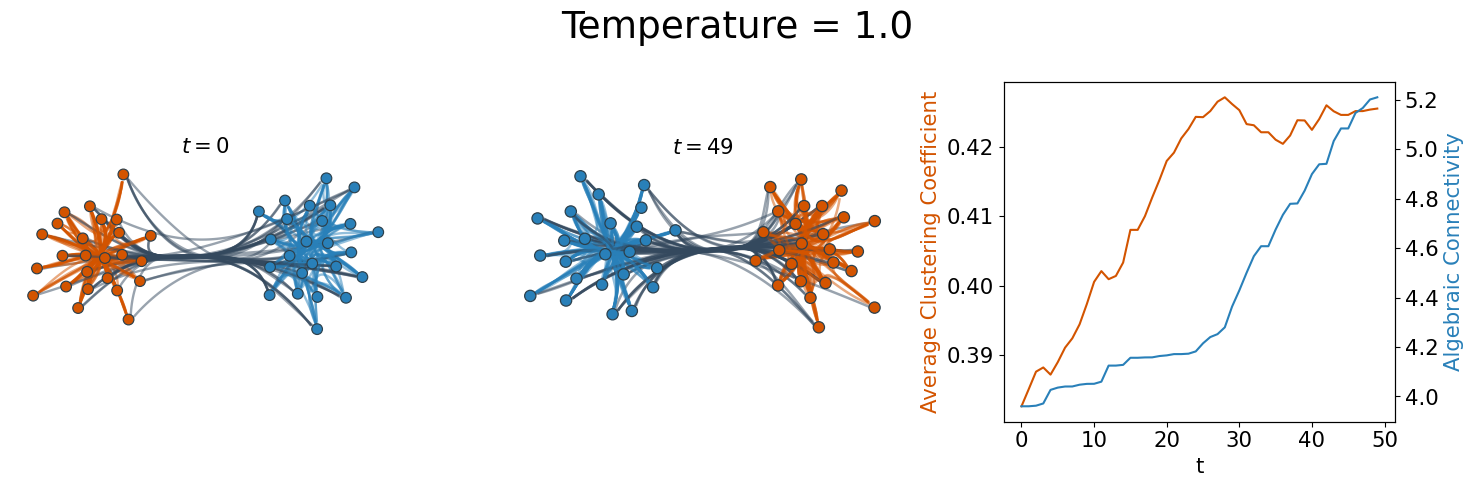

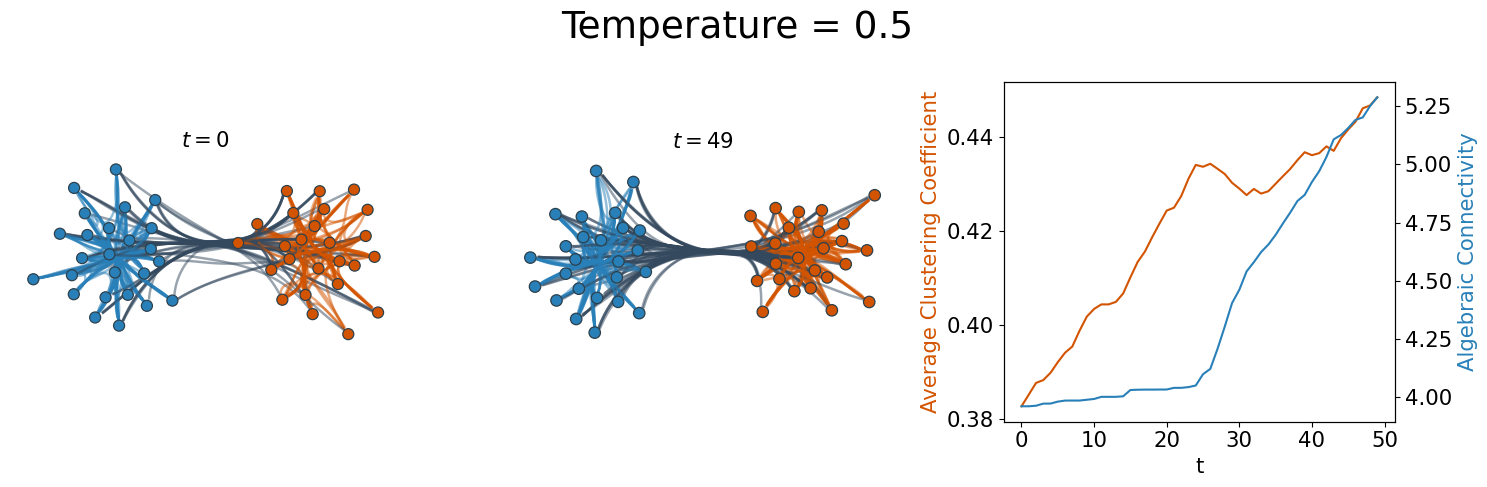

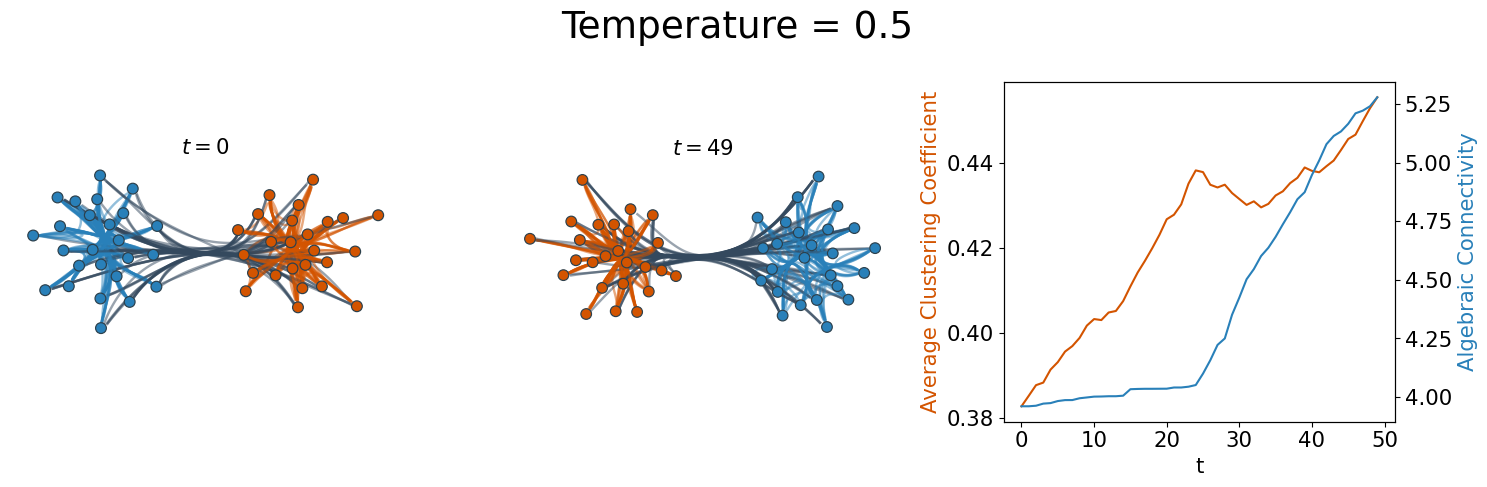

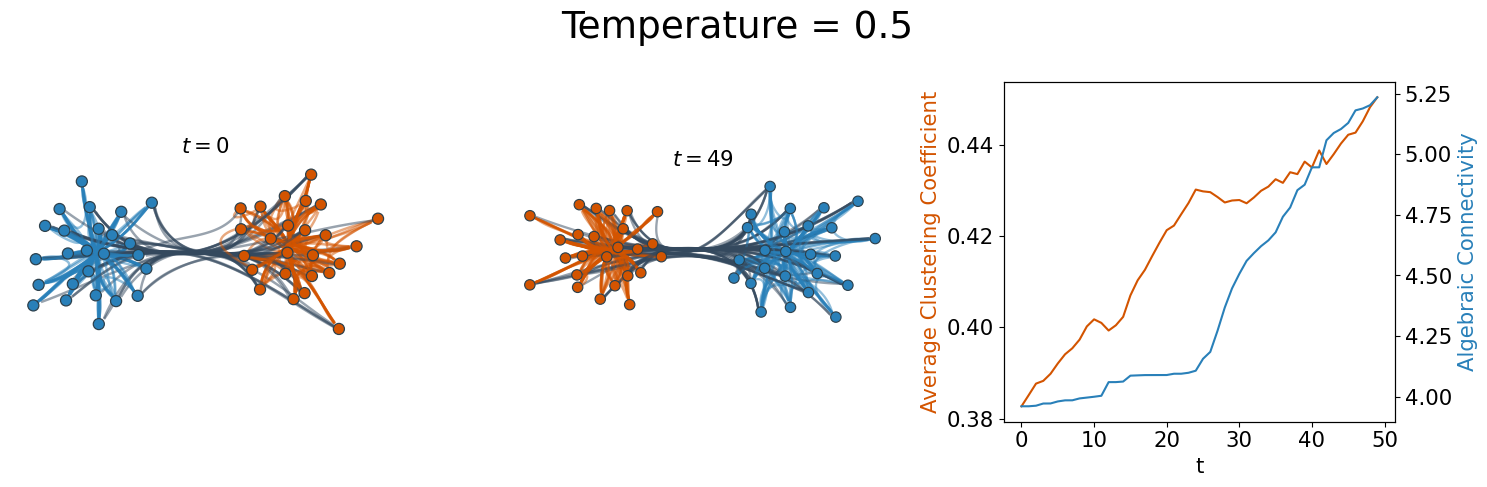

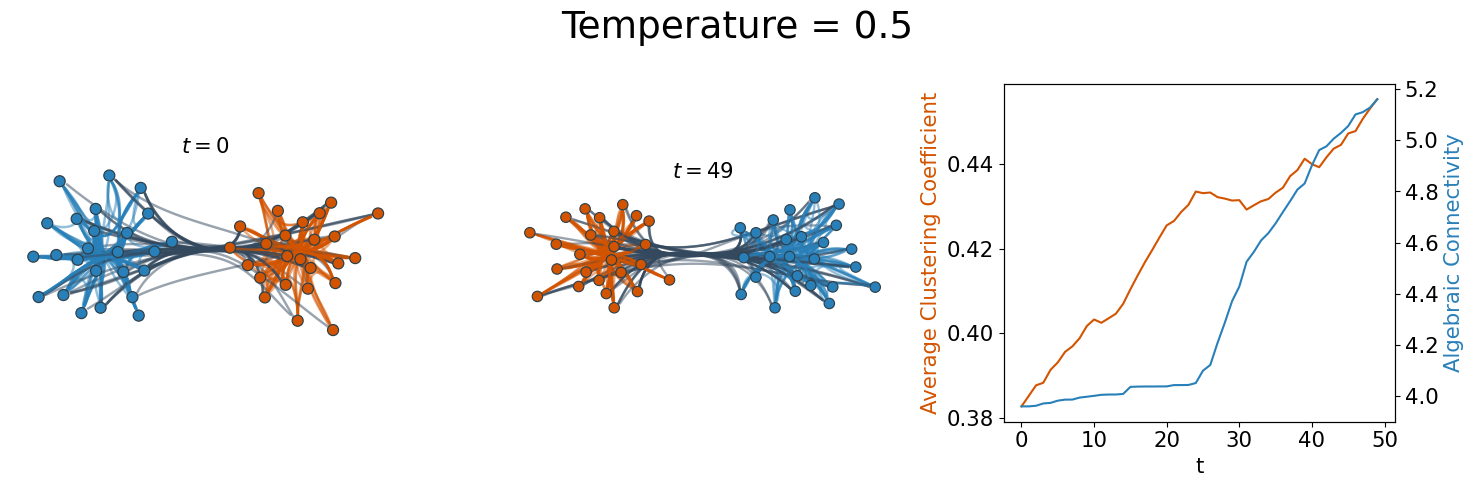

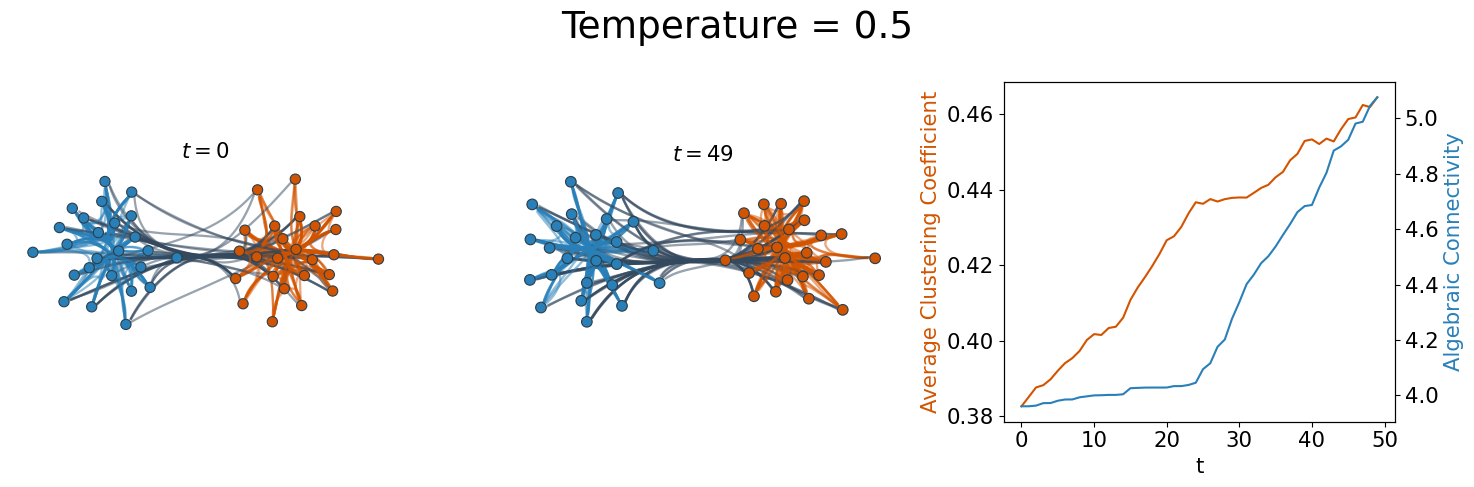

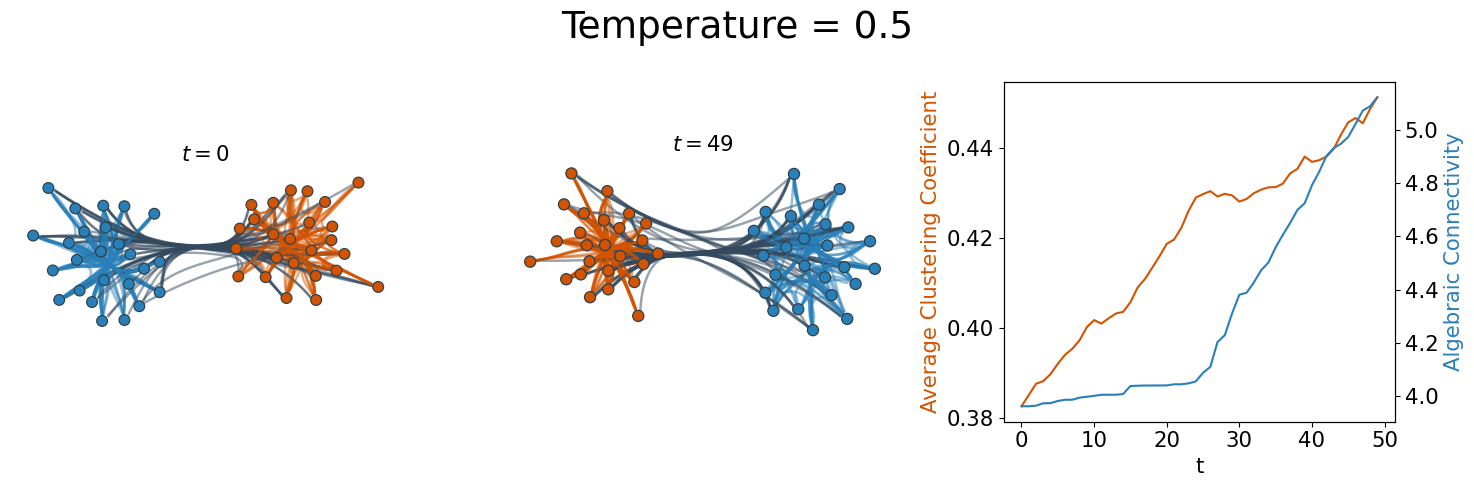

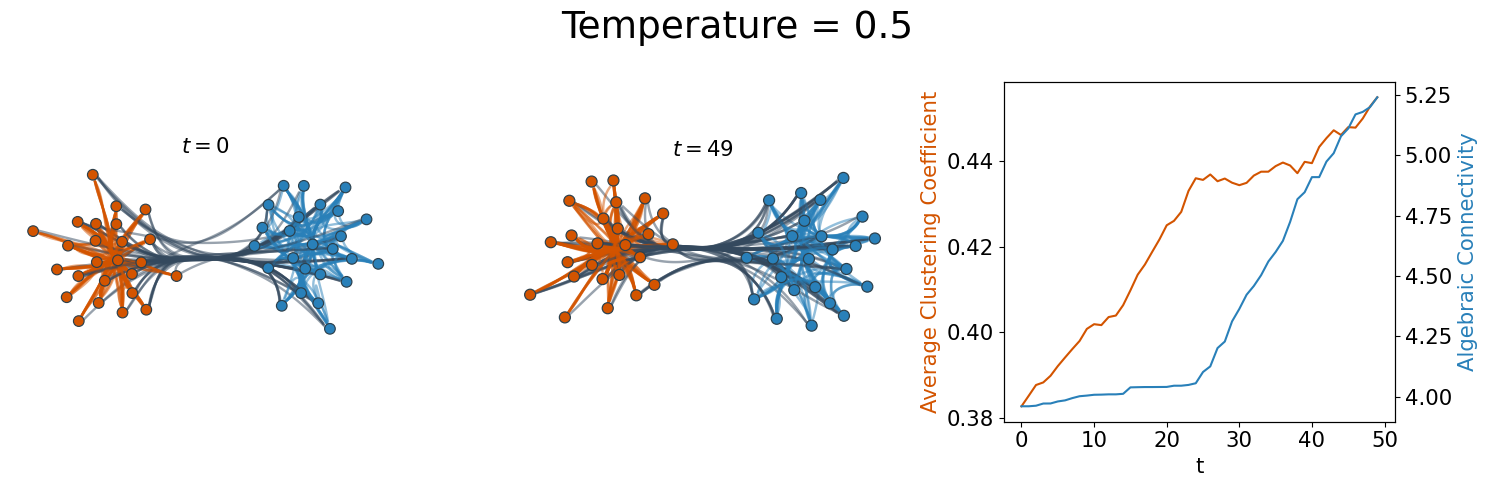

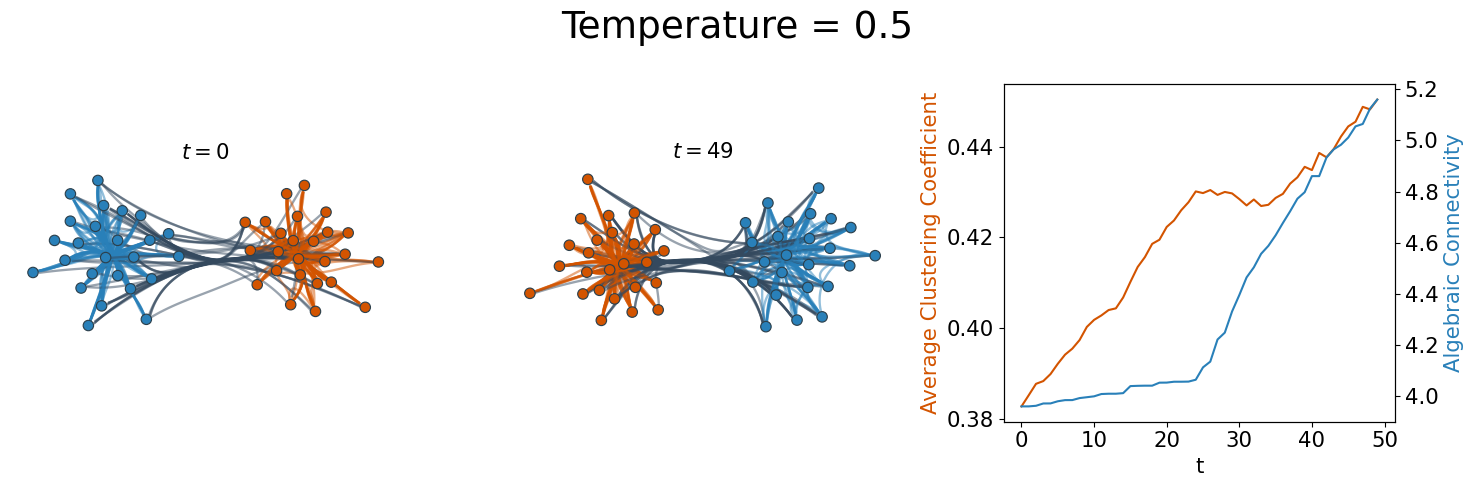

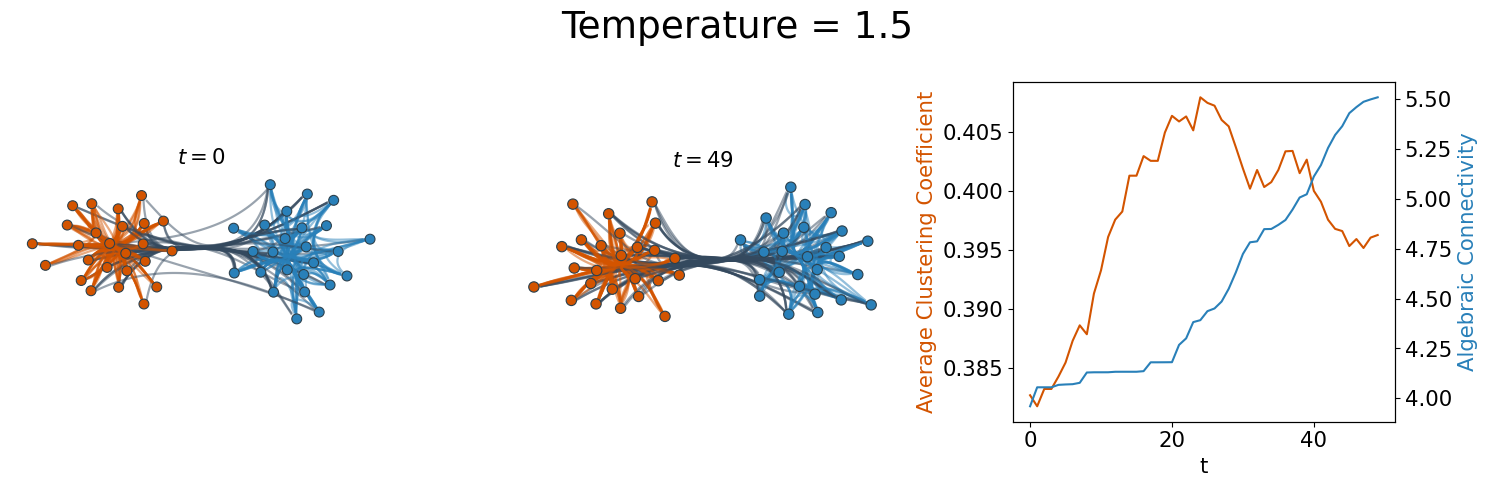

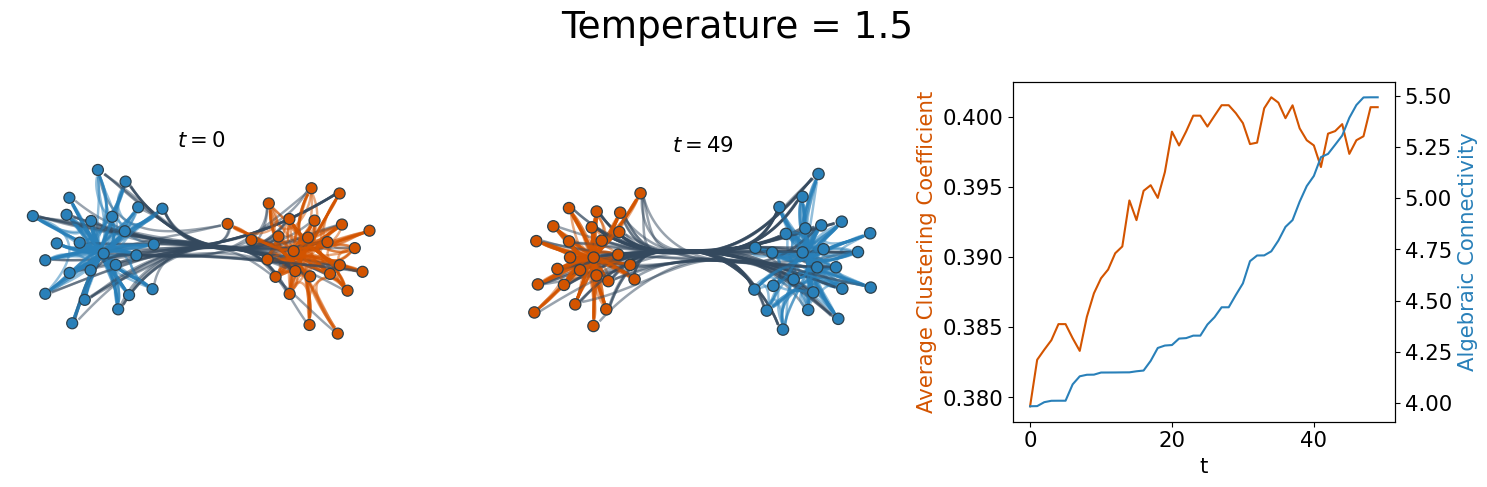

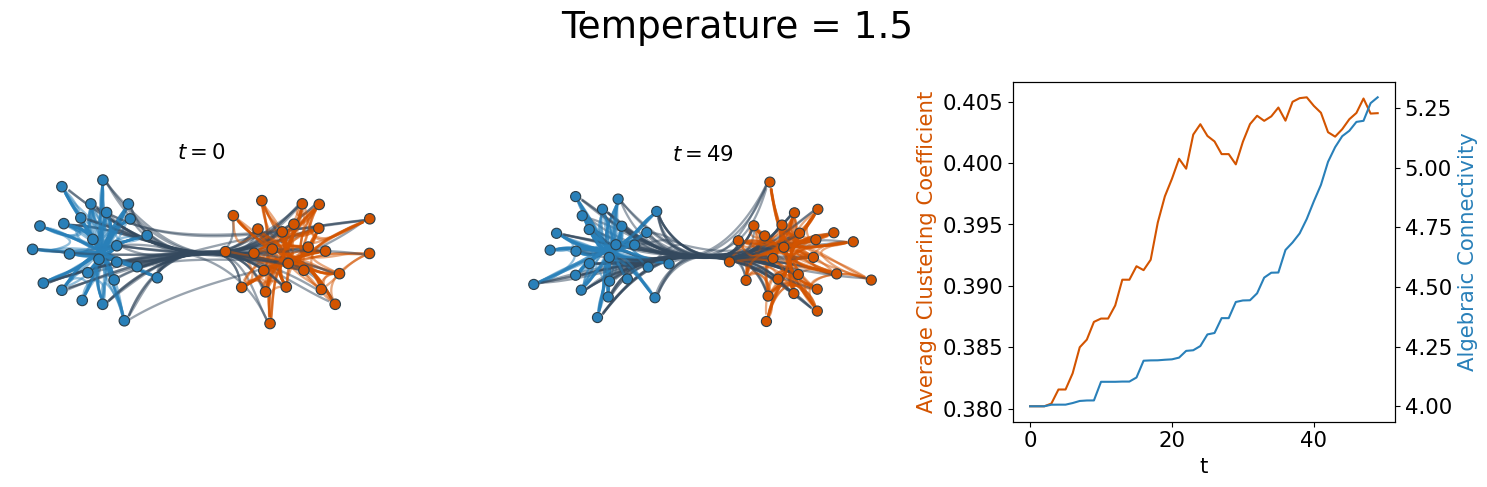

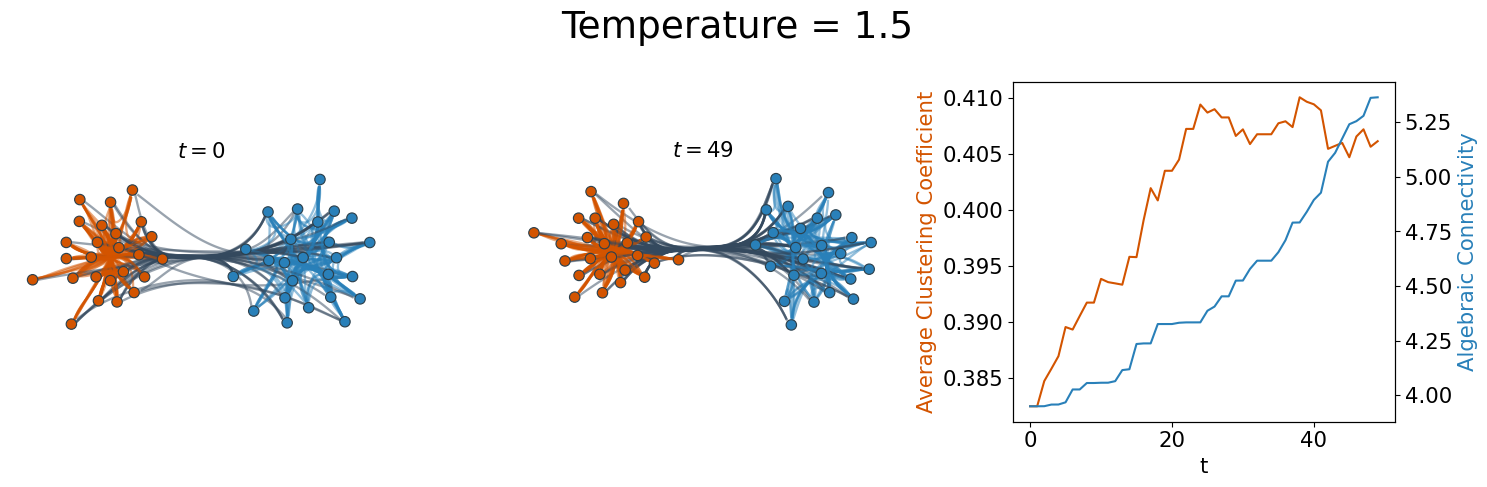

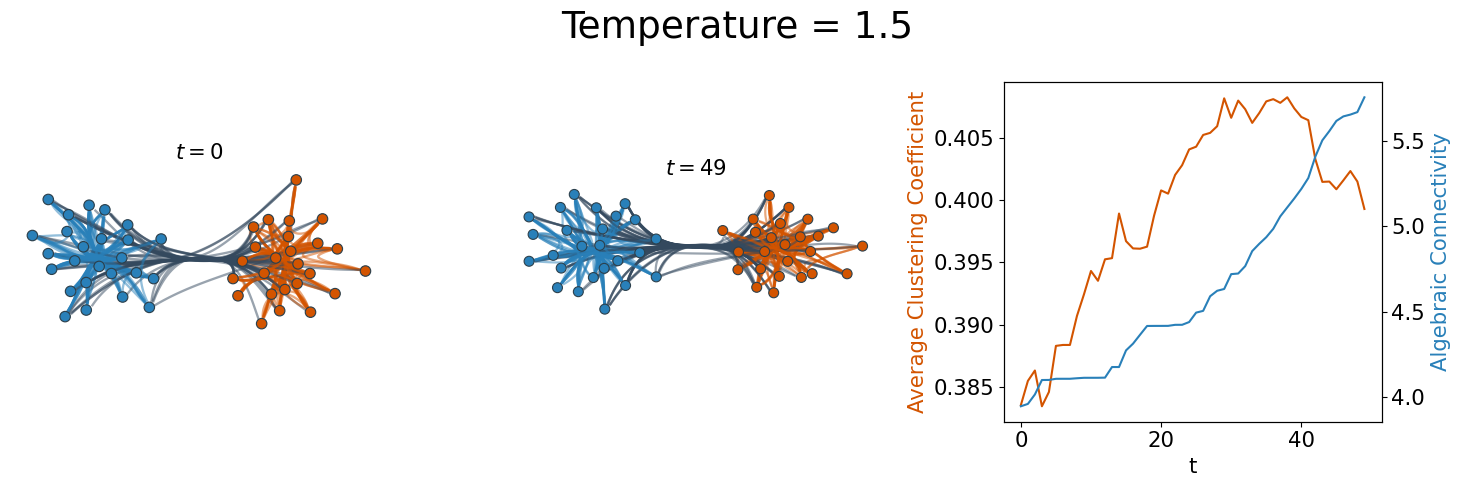

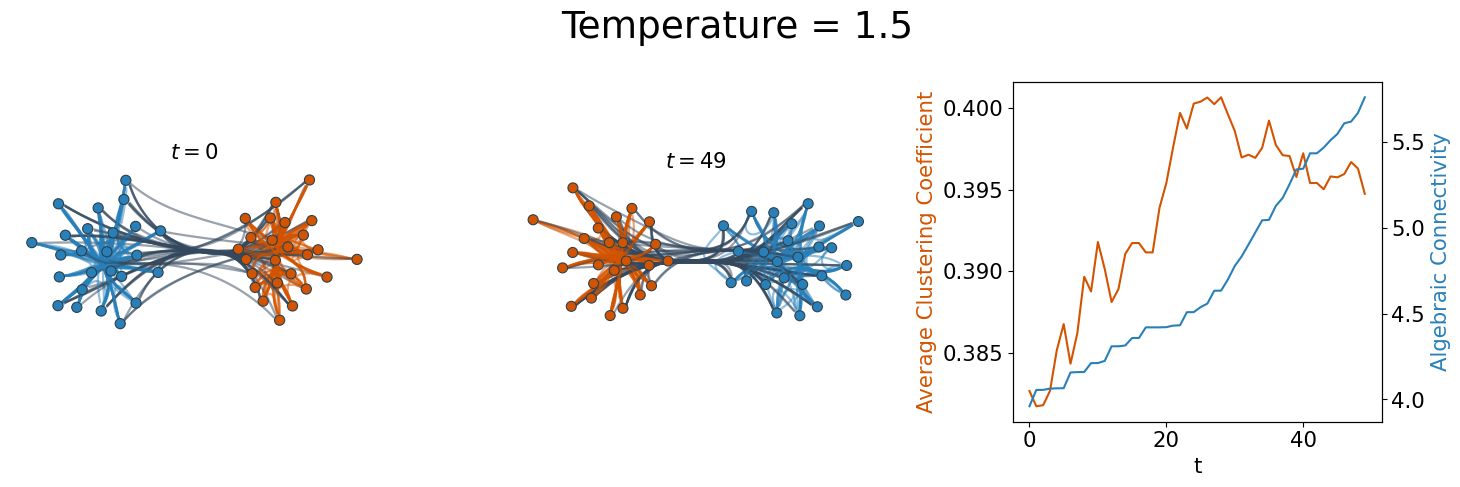

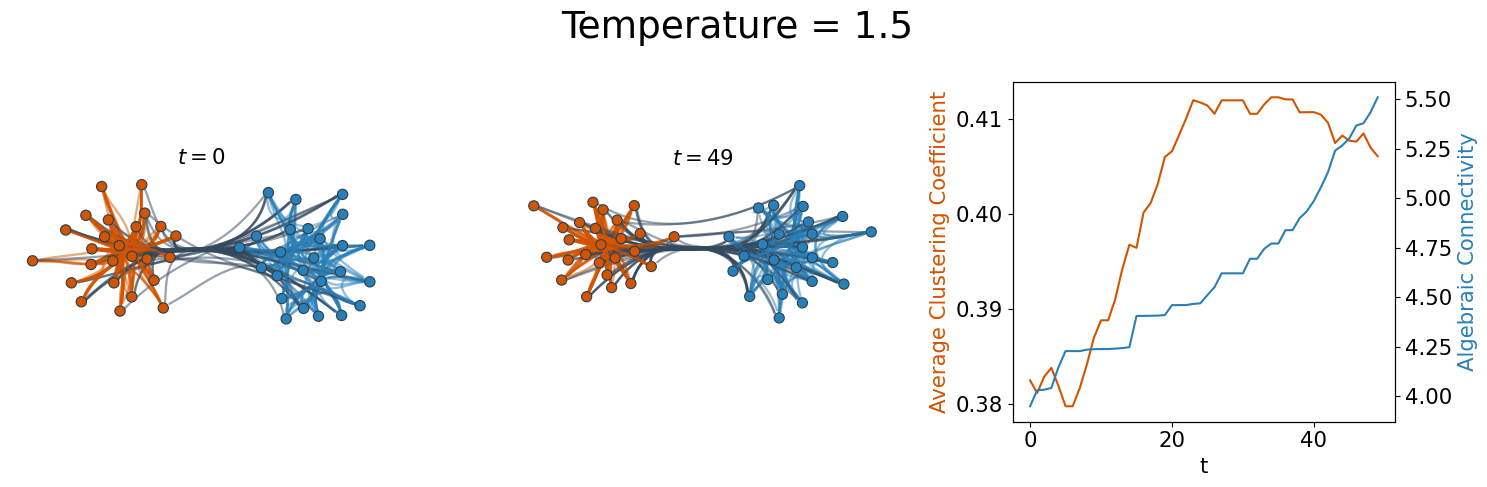

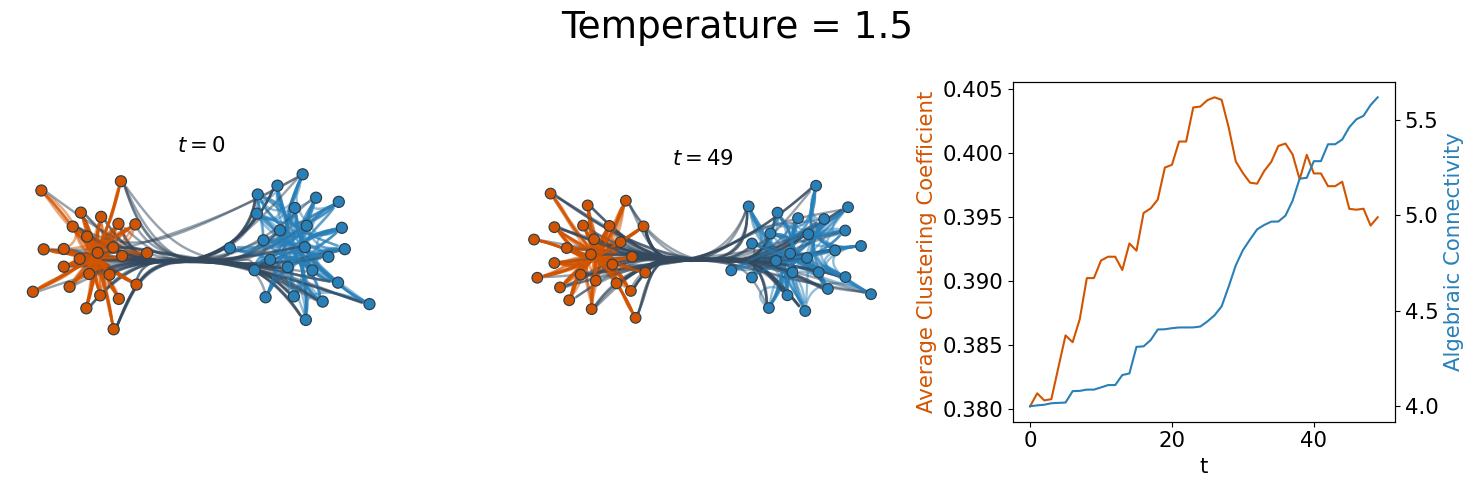

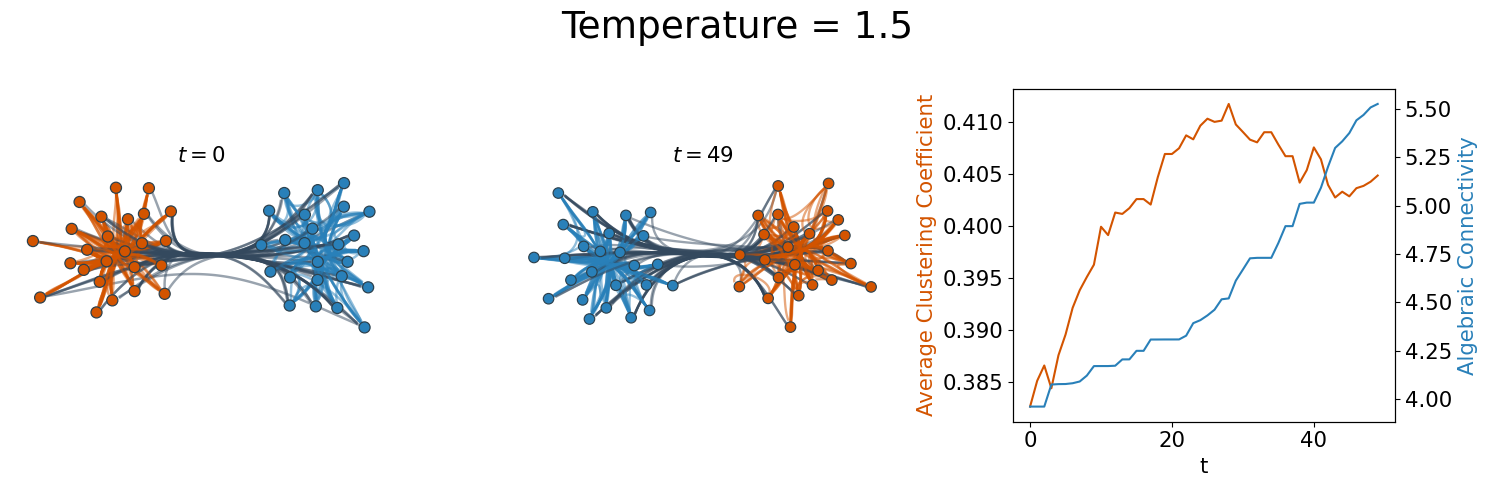

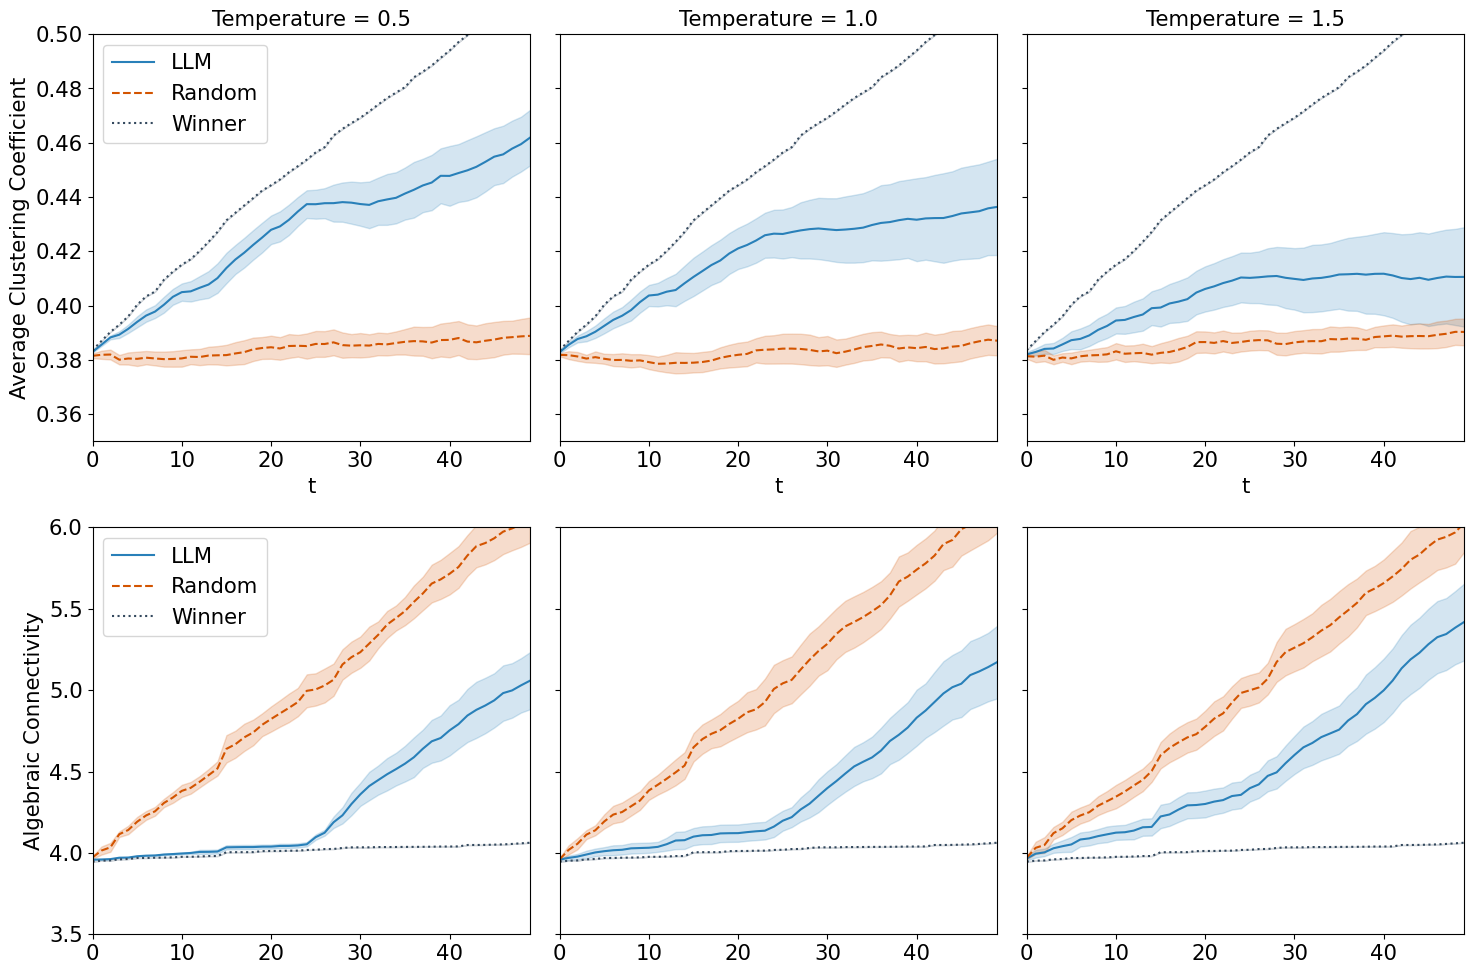

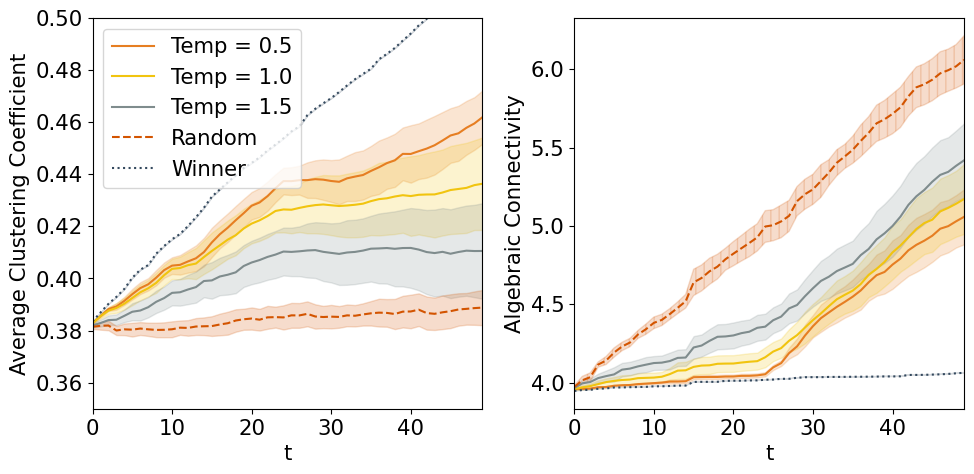

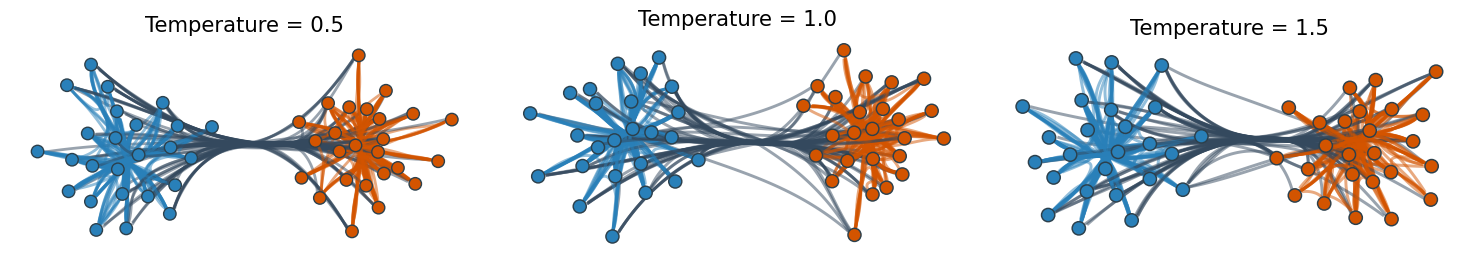

: 

In [2]:
run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_2.jsonl', [0.5, 1.0, 1.5], method='llm')
analyze_experiments('outputs/principle_2.jsonl')

In [ ]:
# summarize_reasons('outputs/principle_2.jsonl')